# Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt


# Load and Prepare Data

In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.

# Reshape the data to include channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Function to add noise
def add_noise(images, noise_factor=0.5):
    noise = np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise_factor * noise
    return np.clip(noisy_images, 0., 1.)

# Add noise to the images
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)





4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# Confirm the shapes
print(f"x_train shape: {x_train.shape}")
print(f"x_train_noisy shape: {x_train_noisy.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"x_test_noisy shape: {x_test_noisy.shape}")

x_train shape: (60000, 28, 28, 1)
x_train_noisy shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_test_noisy shape: (10000, 28, 28, 1)


# Build the Autoencoder Model

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

# Build the Encoder
def build_encoder(input_shape):
    encoder_input = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoder_output = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')
    return encoder


# Build the Decoder
def build_decoder(latent_dim):
    decoder_input = tf.keras.Input(shape=latent_dim)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')
    return decoder

input_shape = (28, 28, 1)
encoder = build_encoder(input_shape)
latent_dim = encoder.output_shape[1:]
decoder = build_decoder(latent_dim)

# Build the Autoencoder
autoencoder_input = tf.keras.Input(shape=input_shape)
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = tf.keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 32)          9568      
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         18785     
                                                                 
Total params: 28353 (110.75 KB)
Trainable params: 28353 (110.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Q6.1: Print the encoder model summary and plot the encoder model

In [5]:
# Test build_encoder
input_shape = (28, 28, 1)
encoder = build_encoder(input_shape)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
Total params: 9568 (37.38 KB)
Trainable params: 9568 (37.38

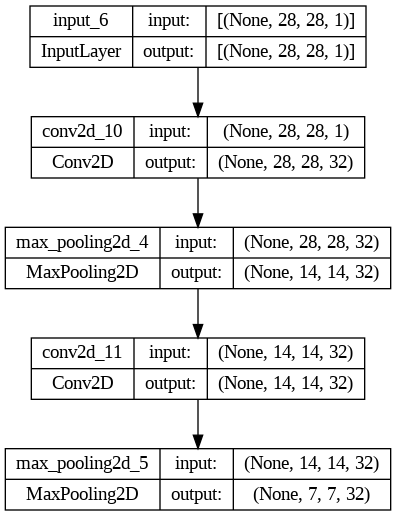

In [14]:
# Plot the encoder
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='encoder_model.png', show_shapes=True, show_layer_names=True)

### Q6.2: Print the decoder model summary and plot the decoder model

In [6]:
# Test build decoder
latent_dim = encoder.output_shape[1:]
decoder = build_decoder(latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 7, 32)]        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 1)         289 

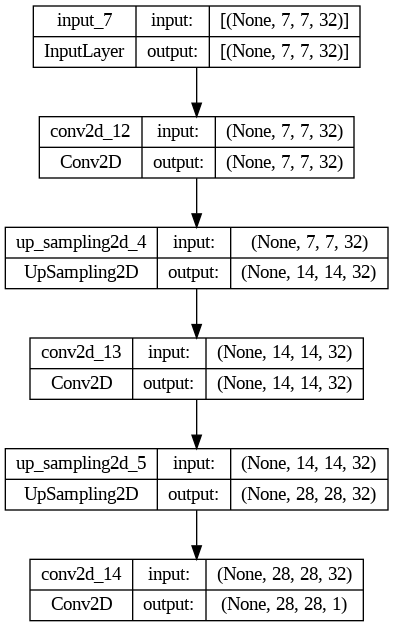

In [15]:
plot_model(decoder, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

# Train the Autoencoder

In [7]:
print(f"x_train_noisy shape: {x_train_noisy.shape}")
print(f"x_train shape: {x_train.shape}")

x_train_noisy shape: (60000, 28, 28, 1)
x_train shape: (60000, 28, 28, 1)


In [8]:
# Train the Autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/50
469/469 [==============================] - 9s 9ms/step - loss: 0.3334 - val_loss: 0.3102
Epoch 2/50
469/469 [==============================] - 5s 10ms/step - loss: 0.3051 - val_loss: 0.3047
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.3012 - val_loss: 0.3022
Epoch 4/50
469/469 [==============================] - 4s 9ms/step - loss: 0.2990 - val_loss: 0.3003
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 0.2973 - val_loss: 0.2986
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2960 - val_loss: 0.2979
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2948 - val_loss: 0.2968
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.2939 - val_loss: 0.2955
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.2930 - val_loss: 0.2953
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.2925 - val_loss: 0.294

# Visualise the training and validation loss

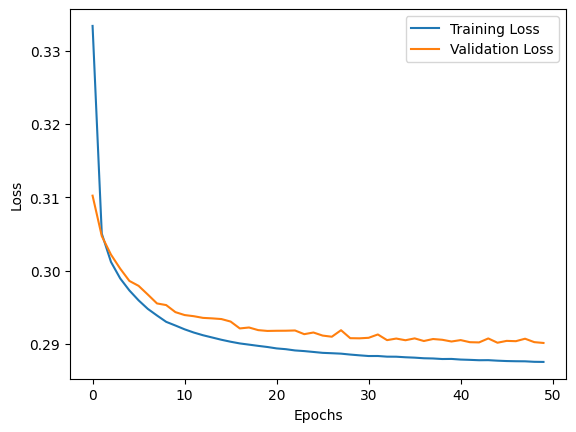

In [9]:
# Plotting the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the Results

In [11]:
# Visualise the results
def evaluate_result(original_images, noisy_images, denoised, n=10):
  plt.figure(figsize=(20, 4))

  for i in range(n):

    ax = plt.subplot(3, n, i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

  plt.show()

313/313 [==============================] - 1s 2ms/step


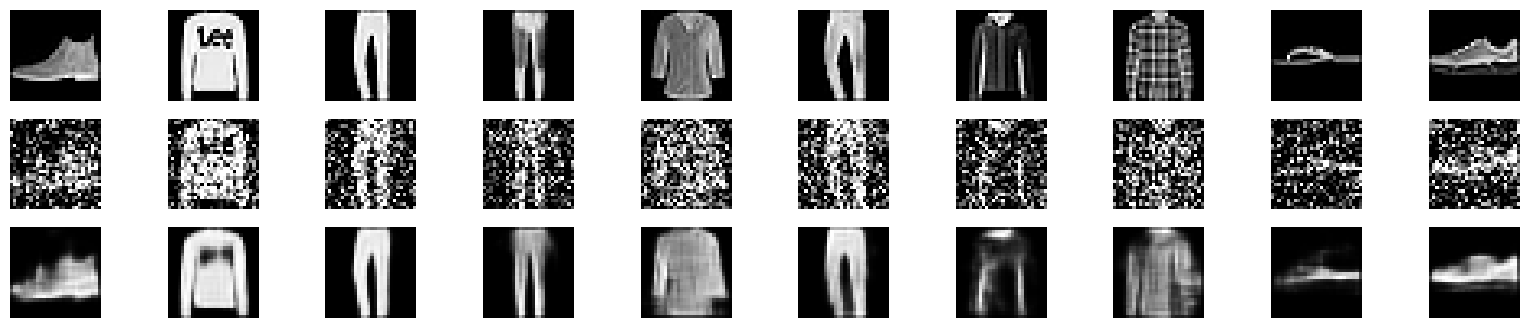

In [12]:
denoised_images = autoencoder.predict(x_test_noisy)
evaluate_result(x_test, x_test_noisy, denoised_images)

### Q6.6



**Two application areas for denoising autoencoders:**

* Image Compression: The encoder compresses the input image into latent-space representation with smaller dimension than original image for efficiently transmitted. The decoder reconstruct image from the compressed presentation. This helps reducing the storage space and bandwidth required for image storage and transmission.

* Anomaly detection: Denoising autoencoders can reconstruct normal data pattern by training on non-anomalous data, which have higher reconstruction error when present. This helps model to detect anomalies in applications such as fraud detection, industrial equipments,...

**For encryption purpose**

I think autoencoder can be adapted for encryption by compressing data into latent-space representation (like image compression), which is an encrypted from of data. The decoder helps reconstruct the original data from latent presentation. This latent presentation helkp with security feature which is not easily to interpretable. The security level also depends the complexity of encoder and decoder with creating more robustnessa and prevent unauthorized access.
